#Import thư viện

In [1]:
!pip install pandas numpy scikit-fuzzy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=3ce2f6cbe8706f2a8cd1b76f7024b2af14d3f16e7c16047e11cf7e273a404752
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [2]:
!pip install dill


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.1 MB/s eta 0:00:00


In [3]:
pip install pyFTS


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 1.5 MB/s eta 0:00:00


In [4]:
%pylab inline
from torch.utils.data import DataLoader
import torch.nn as nn
from pyFTS.partitioners import Grid
from pyFTS.models import chen, cheng
from pyFTS.common import Util , Transformations
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from pyFTS.benchmarks import Measures
from pyFTS.common import FuzzySet as fz
from pyFTS.common import FLR
import pandas as pd
import numpy as np
import seaborn as sns
np.int = int
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch.utils.data import TensorDataset, DataLoader
from skfuzzy import control as ctrl

Populating the interactive namespace from numpy and matplotlib


#Tiền xử lý dữ liệu

In [5]:


df = pd.read_csv('/content/AZN.csv')

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
# df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')


size = 0.7
# Tách dữ liệu thành train và test
train_size = int(len(df) * size)
train = df["Close"].values[:train_size]
test = df["Close"].values[train_size:]



## Kiểm tra giá trị NaN trong dữ liệu test

In [6]:

nan_indices = np.isnan(test).nonzero()[0]
if nan_indices.size > 0:
    print("NaN values found in 'test' dataset at indices:", nan_indices)
    # Loại bỏ các dòng có giá trị NaN
    test = test[~np.isnan(test)]

##Biểu đồ Train & Test

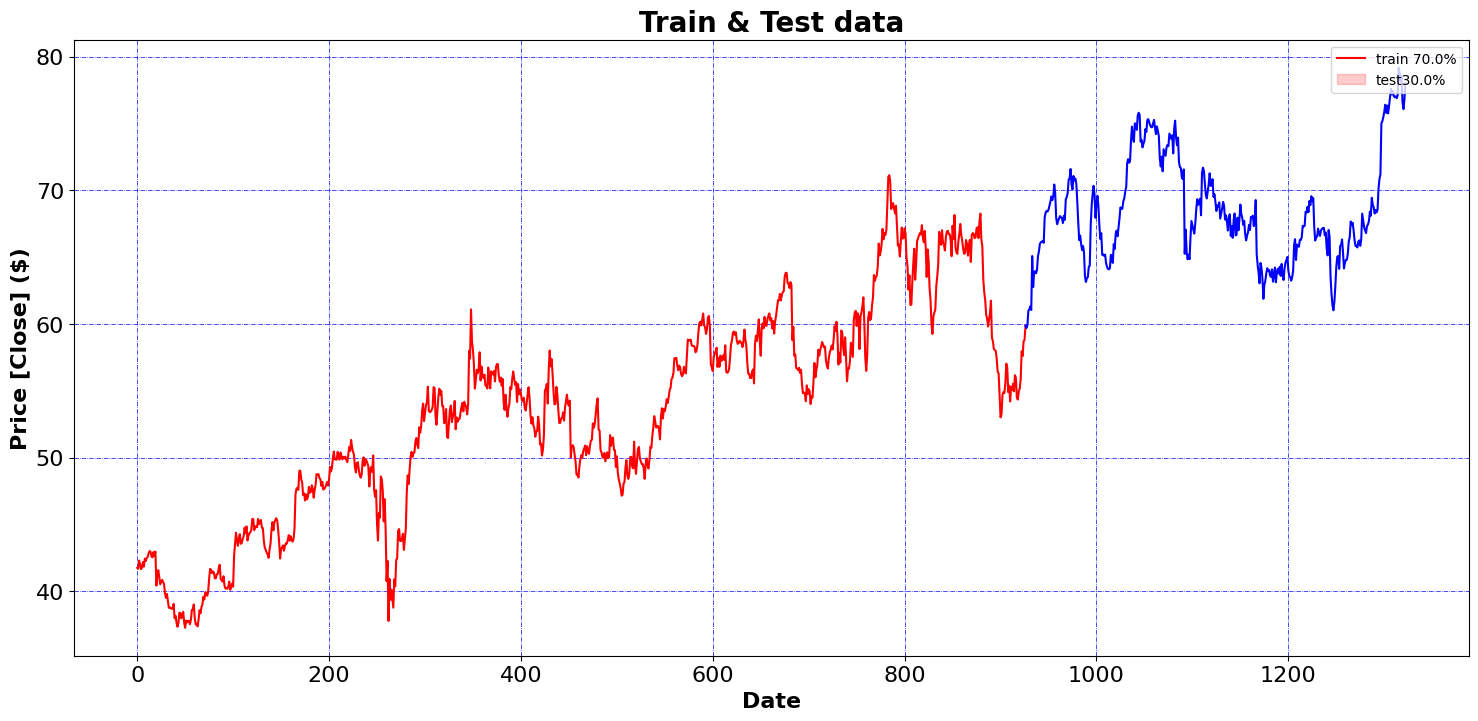

In [7]:

fig, ax = plt.subplots(figsize=(18,8)) # 4.5, 2
sns.lineplot(x = df.index[:train_size+1], y = df['Close'][:train_size+1], color = 'red')
sns.lineplot(x = df.index[train_size:], y = df['Close'][train_size:], color = 'blue')

ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price [Close] ($)', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train ' + str(size*100) + '%', 'test'+ str(100 - size*100) + '%'))
plt.grid(which="major", color='blue', linestyle='-.', linewidth=0.5)
plt.show()

#Phân chia lưới để xác định các tập mờ

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:238: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


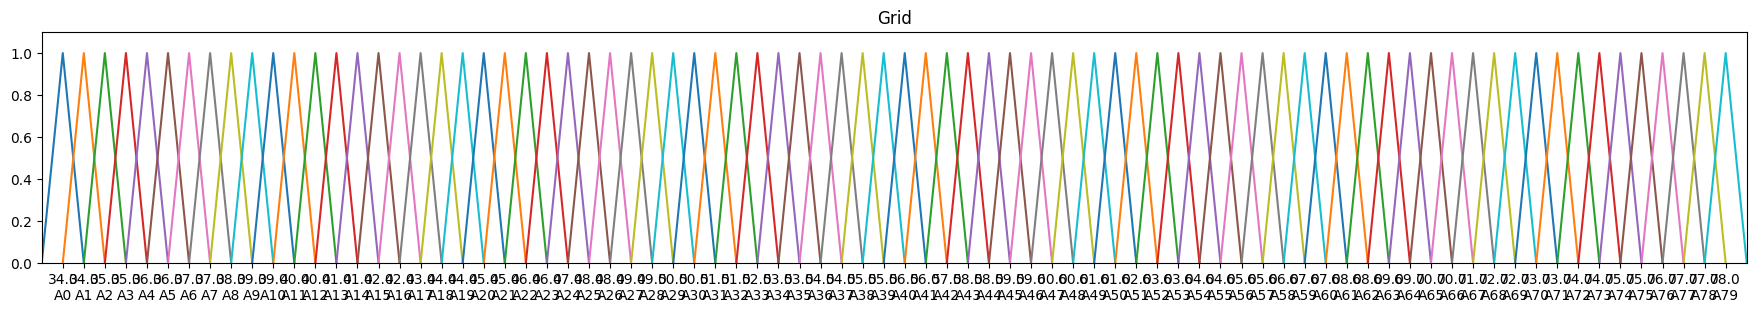

In [8]:
# Phân vùng dữ liệu mờ
part = Grid.GridPartitioner(data=train, npart=80)
test_fuzzy_sets = part.fuzzyfy(test)
train_fuzzy_sets = part.fuzzyfy(train)
mfs = part.sets
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[22, 3])
part.plot(ax)

#Mờ hóa dữ liệu

In [9]:
# Tạo tập hợp mờ từ dữ liệu đã chuẩn hóa
F = fz.fuzzyfy_series(train, part.sets)

#Tạo các quy tắc logic mờ (FLR)

In [10]:
# Tạo các quy tắc Fuzzy Logic Relations (FLR)
rules = FLR.generate_non_recurrent_flrs(F)

#Dự báo và giải mờ

## Hàm lấy trọng tâm (centroid) của tập hợp mờ

In [11]:
def get_centroid(membership):
    if membership in part.sets:
        return part.sets[membership].centroid
    return None

## Hàm defuzz để tính giá trị giải mờ từ các trọng tâm

In [12]:
def defuzz(centroids):
    if centroids:
        return sum(centroids) / len(centroids)
    else:
        return None


##Test prediction

In [13]:
test_predict = [train[-1]]
centroids = []

last_memberships = test_fuzzy_sets[-1]
print(last_memberships)
for i in range(len(test)-1):
    if i < len(test_fuzzy_sets):
        last_memberships = test_fuzzy_sets[i]
    # print("Last memberships:", last_memberships)
    matching_rules = [rule for rule in rules if rule.LHS in last_memberships]
    if matching_rules:
        next_memberships = [matching_rules[-1].RHS]  # Chuyển đổi thành danh sách
        # print("Có quy tắc phù hợp với last_memberships:", matching_rules[-1])
    else:
        next_memberships = last_memberships
        # print("Không có quy tắc nào phù hợp với last_memberships")

    # print("next_membership:", next_memberships)
    last_memberships = next_memberships

    centroids.clear()  # Xóa các centroids trước khi thêm mới

    for membership in next_memberships:
        centroid = get_centroid(membership)
        if centroid is not None:
            centroids.append(centroid)
        else:
            print("Không tìm thấy tập hợp mờ cho nhãn:", membership)
    next_value = defuzz(centroids)  # Định nghĩa next_value
    test_predict.append(next_value)


['A79']


##Dự đoán 90 ngày tiếp theo

In [14]:
next_90_days_predict = [test[-1]]

last_memberships = test_fuzzy_sets[-1]
# print(last_memberships)
for i in range(90):
    if i < len(test_fuzzy_sets):
        last_memberships = test_fuzzy_sets[i]
    matching_rules = [rule for rule in rules if rule.LHS in last_memberships]
    if matching_rules:
        next_memberships = [matching_rules[-1].RHS]  # Chuyển đổi thành danh sách
    else:
        next_memberships = last_memberships
    last_memberships = next_memberships

    centroids.clear()  # Xóa các centroids trước khi thêm mới

    for membership in next_memberships:
        centroid = get_centroid(membership)
        if centroid is not None:
            centroids.append(centroid)
        else:
            print("Không tìm thấy tập hợp mờ cho nhãn:", membership)
    next_value = defuzz(centroids)  # Định nghĩa next_value
    next_90_days_predict.append(next_value)
    # last_value_scaled = next_value

# test_predict = scaler.inverse_transform(np.array(test_predict).reshape(-1, 1))


#Đánh giá hiệu suất mô hình với MAPE, RMSE và MSE

In [15]:
mape = mean_absolute_percentage_error(test, test_predict)
rmse = np.sqrt(mean_squared_error(test, test_predict))
mse = mean_squared_error(test, test_predict)
mae = mean_absolute_error(test, test_predict)

print(f"MAPE: {mape}")
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MAPE: 0.024029739220920072
RMSE: 1.9684910295313358
MSE: 3.874956933345338
MAE: 1.6091132461208921


# Vẽ biểu đồ

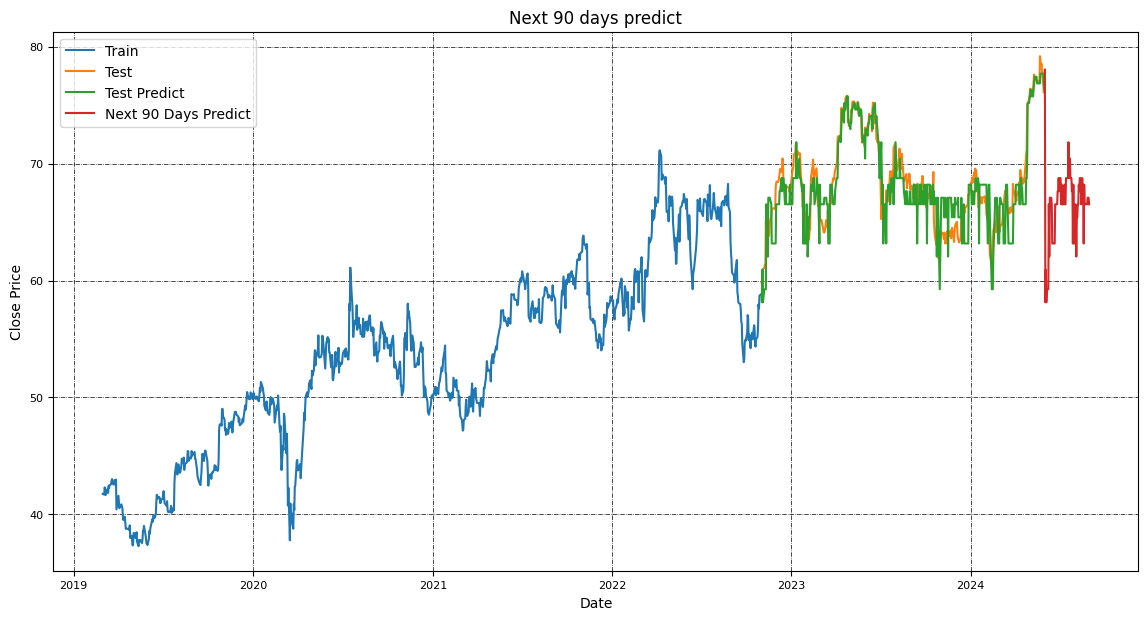

In [16]:
next_90_days_dates = pd.date_range(df['Date'].iloc[-1], periods=91, freq='D')

plt.figure(figsize=(14, 7))
plt.plot(df['Date'][:train_size], train, label='Train')
plt.plot(df['Date'][train_size:], test, label='Test')
plt.plot(df['Date'][train_size:train_size+len(test_predict)], test_predict, label='Test Predict')
plt.plot(next_90_days_dates, next_90_days_predict, label='Next 90 Days Predict')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.legend(loc='upper left')
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.title('Next 90 days predict')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()
